# 制御コードのロード（最初に一度だけ実行する部分）

実験信号の継続時間を変更する場合には再度 qubecalib.meas.SimpleSendRecvProto のインスタンスを生成し直してください．

In [37]:
import qubecalib as qc
from qubecalib import Qube, PortFunc, Lane, PortNo
from qubecalib.meas import SimpleSendRecvProto
import qubecalib.meas
from e7awgsw import CaptureModule, CaptureCtrl, CaptureUnit, CaptureParam, AwgCtrl, WaveSequence, DspUnit, IqWave, get_null_logger, AWG, AwgCtrlRegs
import numpy as np

qube = Qube(config_file_name='qube_riken_1-07.yml')
o = SimpleSendRecvProto(
    duration = 1000e-9, # 波形継続時間（目安）
    wait_words = 0, # 1 ワード当たり 4 サンプル (500Msps で 8 ns)
    readin_port = qube[PortFunc.Readin1],
    readout_awg = qube.awg[PortFunc.Readout1]
)
o.capture_delay = 0.85e-6 # 冷凍機内へ打ち込んだ信号の応答が帰ってくるまでの遅延のための待機時間
o.additional_capture_length = 0.2e-6 # 追加でサンプルする時間
o.repeats = 1 # 積算回数

a = qube.awg[PortFunc.Readout1]
w = o.new_sequence(a) # 最初に登録した awg が trigger となります
o.wave_property[a].mhz = 0 # MHz
# o.assign(qube.awg[PortFunc.Readout2], w)

a = qube.awg[PortFunc.Ctrl2][Lane.L0]
w = o.new_sequence(a)
o.wave_property[a].mhz = 0 # MHz
o.trigger = a

# 周波数変更部分

**LO 周波数を変更すると検波位相が変動してしまうので注意！**

In [38]:
p = PortFunc.Readout1 # ポートの選択
cnco_mhz, awg_mhz = qube[p].set_freq(10000, 9000) # 周波数の設定 (Coarse NCO)
qube[PortFunc.Readin1].adc.nco.freq = cnco_mhz
o.wave_property[qube.awg[p]].mhz = awg_mhz # AWG の変調周波数 (-200MHz ~ +200MHz ぐらいが実用範囲？)
qube[p].vatt = 0x800 # 出力の設定
print('AWG Frequency (Readout1) {} MHz'.format(awg_mhz), flush=True)

p = PortFunc.Ctrl2
nco_mhz, awg_mhz = qube[p].set_freq(10000, 11000)
o.wave_property[qube.awg[p][Lane.L0]].mhz = awg_mhz
qube[p].vatt = 0x800
print('AWG Frequency (Ctrl2) {} MHz'.format(awg_mhz), flush=True)

['{}: {}'.format(k, v.status) for k, v in qube.port.items()]

AWG Frequency (Readout1) 15.625 MHz
AWG Frequency (Ctrl2) -15.625 MHz


['0: RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive',
 '1: RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz ',
 '5: RF = 11000.000 MHz LO = 12000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '6: RF = 10000.000 MHz LO = 11000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '7: RF = 9984.375 MHz LO = 11000    MHz IF = 1015.625 MHz LSB/USB: LSB MODE AWG: Inactive',
 '8: RF = 10000.000 MHz LO = 11000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '12: RF = 9984.375 MHz LO =  9000    MHz IF = 984.375 MHz ',
 '13: RF = 9984.375 MHz LO =  9000    MHz IF = 984.375 MHz LSB/USB: USB MODE AWG: Inactive']

# 波形設定部分

In [39]:
w = o.sequence[qube.awg[PortFunc.Readout1]]
t = w.timeline
w.iq[:] = 0
w.iq[(500e-9 <= t) & (t < 900e-9)] = 1.0 + 1j * 0.0

w = o.sequence[qube.awg[PortFunc.Ctrl2][Lane.L0]]
t = w.timeline
w.iq[:] = 0
w.iq[(60e-9 <= t) & (t < 320e-9)] = 1.0 + 1j * 0.0


(0.0, 1.2e-06)

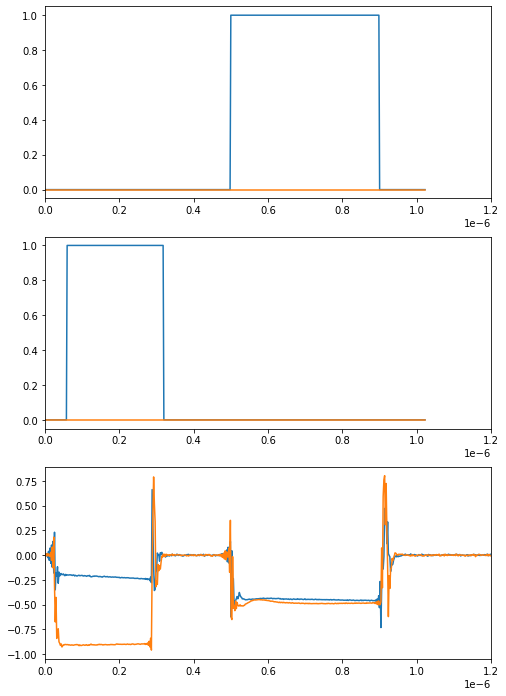

In [77]:
o.capture_delay = 0.85e-6 # 冷凍機内へ打ち込んだ信号の応答が帰ってくるまでの遅延のための待機時間


%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,1, figsize=(8,12))

awg = qube.awg[PortFunc.Readout1]
a = np.array(o.sequence[awg].iq)
t = np.array(o.sequence[awg].timeline)
ax[0].plot(t,np.real(a))
ax[0].plot(t,np.imag(a))
ax[0].set_xlim(0, 1.2e-6)
awg = qube.awg[PortFunc.Ctrl2][Lane.L0]
a = np.array(o.sequence[awg].iq)
t = np.array(o.sequence[awg].timeline)
ax[1].plot(t,np.real(a))
ax[1].plot(t,np.imag(a))
ax[1].set_xlim(0, 1.2e-6)

d = o.start()

a = d[CaptureUnit.U0]
b, t = o.downconv(a, qube.awg[PortFunc.Readout1])
ax[2].plot(t, np.real(b) / np.max(np.abs(b)))
ax[2].plot(t, np.imag(b) / np.max(np.abs(b)))
ax[2].set_xlim(0, 1.2e-6)
